# Phenotyping lab notebook

This notebook is meant to help you perform phenotyping on your data by connecting to your database (following the OMOP schema) and import your data, perform phenotyping, and report the results


* config file placed in main directory will specify which version of python,and packages are needed

The next block imports important system packages needed

In [1]:
## base packages
import numpy as np
import pandas as pd
import time
from collections import Counter
from collections import OrderedDict
import os
import sys
import operator
import datetime

## Tensor Factorization Packages
sys.path.append("./code/tensor/")
import tensorIO
import time
import marbleAPR


## Initial Clustering Packages
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

## Consensus Cluster Determination Packages
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage



## Regression / Classification Packages
### feature selection / model selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

### classification
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### cross validation
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

### metrics
from sklearn.metrics import roc_curve, auc
from scipy import interp

## COX
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

## Plotting packages
%matplotlib inline
import matplotlib.pyplot as plt



## database connectors
import sqlite3



/Users/rchen/miniconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/rchen/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## connect to database (OMOP)

first we need to connect to a database, and specify the data wanted for phenotyping. In this example, we are assuming a SQLite database as demonstration. The following code block can be replaced a database connector for any database type (e.g., PostgreSQL, MySQL). 


* replace database name and login info with your database info
* specify which concepts you want to include in the phenotyping task. these can include for example, medications and conditions
* database should follow the OMOP schema

In [2]:
import sqlite3


## connecting to the database
conn = sqlite3.connect('/path/to/omop/database')
c = conn.cursor()



### database: grab concept table

concept table is REQUIRED. this table encodes the concept ID and description of the concep


In [3]:
c.execute('SELECT * FROM CONCEPT')
l_concept_table_columns = c.description
l_concept_table_columns_names = [x[0] for x in l_concept_table_columns]
df_CONCEPT = pd.DataFrame(c.fetchall(),columns = l_concept_table_columns_names )

## specify OMOP concepts used for phenotyping

below, please specify the clinical data tables used in the phenotyping task. 
* code this as a list of strings, each of which correspond to a table
* for this example we will use the following tables:
    - DRUG_EXPOSURE
    - CONDITION_OCCURRENCE

In [4]:
# l_clinical_data_tables = ['CONDITION_OCCURRENCE', 'DRUG_EXPOSURE' ]
# l_clinical_data_date_columns = [ 'condition_start_date', 'drug_exposure_start_date']
# l_clinical_data_concept_id_columns = ['condition_source_concept_id', 'drug_concept_id']
# l_clinical_data_feature_labels = ['CONDITION', 'MEDICATION'] ## your label for each of the features

In [5]:
l_clinical_data_tables = ['CONDITION_OCCURRENCE' ]
l_clinical_data_date_columns = [ 'condition_start_date']
l_clinical_data_concept_id_columns = ['condition_source_concept_id']
l_clinical_data_feature_labels = ['CONDITION'] ## your label for each of the features

## specify any filtering of patients or concepts
below, please specify any filtering of patients or concepts you would like to perform. This can be done by either creating a list of concepts (within each of the data tables) as inclusions or exclusions to make

In [6]:
## specify concepts to exclude here; if none, set l_concept_codes_exclude = []   
l_concept_codes_exclude = pd.read_csv('./data/df_CMS_hf_concept_id_exclusion.csv', header = None)[0]

### determining index dates, observation periods


In [7]:
l_concept_codes_exclude = [str(x) for x in l_concept_codes_exclude]

## Phenotyping: Data Processing

In this section some preliminary data processing is completed. This section is tailored towards processing data for **K-means**. 

For the K-means task, a feature matrix is created, which will be used in execution of the K-means algorithm for clustering patients



In [8]:
## create co-occurrences of events from selected data tables

## load selected data table, merge with other data tables

df_all_features = pd.DataFrame([])
print "generating co-occurrence data frames for NTF. tables used: ------"
l_tables_for_phenotyping = []
d_tables_for_phenotyping = dict()
for i in range(len(l_clinical_data_tables)):
    ## grab the table name and the required column numbers
    table_name = l_clinical_data_tables[i]
    concept_id_col = l_clinical_data_concept_id_columns[i]
    date_col = l_clinical_data_date_columns[i]
    this_data_table_label = l_clinical_data_feature_labels[i]
    
    print '\t', table_name
    #grab table from database
    c.execute('SELECT * FROM ' + table_name  )
    l_this_table_columns = c.description
    l_this_table_columns_names = [x[0] for x in l_this_table_columns]
    df_this_table = pd.DataFrame(data = c.fetchall(), columns = l_this_table_columns_names)
    
    
    df_this_table_subset = df_this_table[['person_id', date_col, concept_id_col ]] #person, date concept id
    df_merge_this_table_subset_concept = pd.merge(df_this_table_subset, df_CONCEPT[['concept_id', 'concept_name']], left_on = concept_id_col, right_on='concept_id', how='outer' )

    ## exclude features that shoulde be excluded; this should be defined in previous code block
    df_merge_this_table_subset_concept = df_merge_this_table_subset_concept[ ~(df_merge_this_table_subset_concept['concept_id'].isin(l_concept_codes_exclude))]
    
    ## new dataframe: person, date, concept_name
    df_this_table_for_phenotyping = pd.DataFrame([])
    df_this_table_for_phenotyping[0] = df_merge_this_table_subset_concept['person_id']
    df_this_table_for_phenotyping[1] = df_merge_this_table_subset_concept[date_col]
    df_this_table_for_phenotyping[this_data_table_label] = df_merge_this_table_subset_concept['concept_name']
    
    df_this_table_for_phenotyping[1] = pd.to_datetime(df_this_table_for_phenotyping[1]) # convert to datetime
    
    l_tables_for_phenotyping.append(df_this_table_for_phenotyping)
    d_tables_for_phenotyping[i] = df_this_table_for_phenotyping

generating co-occurrence data frames for NTF. tables used: ------
	CONDITION_OCCURRENCE


### * data processing: filter out rare events

In [125]:
d_counter_condition = Counter(df_all_features['CONDITION'])


## sort by value
d_counter_condition_sorted = sorted(d_counter_condition.items(), key=operator.itemgetter(1), reverse=True)

## list of conditions and drugs to include (top 250 by occurrence #)
l_conditions_include = [x[0] for x in d_counter_condition_sorted[0:250]]


### * data processing: build feature matrix

build the feature matrix

In [139]:
df_all_features = df_all_features[df_all_features['CONDITION'].isin(l_conditions_include)]


In [140]:
num_modes_non_pts = len(d_tables_for_phenotyping)
l_pts_unique = list(np.unique(df_all_features[0]))
num_pts = len(l_pts_unique)

## build feature index dictionaries
l_features_all = list(np.unique(df_all_features['CONDITION']))

nparr_features_all = np.array(l_features_all)



In [141]:
num_features_total = len(l_features_all)
d_feature_all_idx = dict(zip(l_features_all, range(len(l_features_all)) ) )

In [145]:
## build feature matrix
nparr_feature_matrix = np.zeros([num_pts, num_features_total])
for idx in range(len(l_pts_unique)):
	if np.mod(idx, 100) ==1:
		print idx
	this_pt = l_pts_unique[idx]

	df_this_pt = df_all_features[df_all_features[0]==this_pt]
	# loop through modes
	for mode_idx in range(0, num_modes):
		l_feature_idx_this_mode_this_pt = [d_feature_all_idx[x] for x in df_this_pt['CONDITION']]
		for item in l_feature_idx_this_mode_this_pt:
			nparr_feature_matrix[idx, item] += 1

## convert to BINARY
idx_nnz = np.nonzero(nparr_feature_matrix)
nparr_feature_matrix_BINARY = np.zeros(nparr_feature_matrix.shape)
nparr_feature_matrix_BINARY[idx_nnz] = 1

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
3901
4001
4101


In [146]:
########################################################################################
#  BOOTSTRAPS
#    - you can do multiple bootstraps, but for this example, we will just use one 
#       bootstrap including all the patients
########################################################################################
num_bootstraps = 1
pct_patients_per_bootstrap = 1
num_consensus_clusters = 10

l_clustering_results = []
ll_bootstrap_patient_membership = []
## do BOOTSTRAPS
for iter in range(num_bootstraps):
    print "clustering bootstrap: " + str(iter)  

    random_state = np.random.RandomState(int(time.time())) #random state, truly random each time clustering is run

    pts_to_include_this_bootstrap = np.random.choice( range(num_pts), np.floor(num_pts * pct_patients_per_bootstrap), replace = False)
    d_this_bootstrap_pt_origIdx_newIdx = dict()
    # build mapping ORIG PT INDEX ==> NEW PT INDEX (JUST FOR BOOTSTRAP)
    for pt in pts_to_include_this_bootstrap:
        d_this_bootstrap_pt_origIdx_newIdx[pt] = len(d_this_bootstrap_pt_origIdx_newIdx)
    ll_bootstrap_patient_membership.append(d_this_bootstrap_pt_origIdx_newIdx)
    
    ## currently using K-MEANS
    clustering_algo = KMeans(n_clusters=num_consensus_clusters, random_state = random_state)   ## can change this: Hclust, etc.

    clustering_result = clustering_algo.fit(nparr_feature_matrix_BINARY[pts_to_include_this_bootstrap,:]) ## run clustering on SUBSET of patients (just those chosen for bootstrap!)


    #    clustering_result = clustering_algo.fit(nparr_feature_matrix)
    l_clustering_results.append(clustering_result)
    #print Counter(clustering_result.labels_)


## store off the cluster assignments
od_cluster_assignments_by_pts = OrderedDict()
for a in range(num_pts):
    od_cluster_assignments_by_pts[a] = []
    for k in range(num_bootstraps):
        if a in ll_bootstrap_patient_membership[k]:
            od_cluster_assignments_by_pts[a].append(l_clustering_results[k].labels_[ll_bootstrap_patient_membership[k][a]])
        else:
            od_cluster_assignments_by_pts[a].append(np.nan)



clustering bootstrap: 0


/Users/rchen/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## plot assignment of patients to clusters in first bootstrap clustering

go thru od_cluster_assignments_by_pts, for each patient, find cluster assignment

* display histogram of # patients belonging to clusters


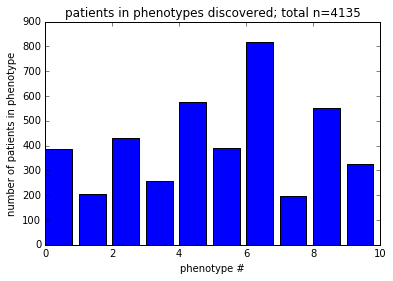

In [147]:
l_pts_cluster_assignment_bootstrap_1 = []
l_pts = od_cluster_assignments_by_pts.keys()
for pt in l_pts:
    l_pts_cluster_assignment_bootstrap_1.append(od_cluster_assignments_by_pts[pt][0])

df_cluster_assignment_bootstrap_1 = pd.DataFrame([])
df_cluster_assignment_bootstrap_1[0] = l_pts
df_cluster_assignment_bootstrap_1[1] = l_pts_cluster_assignment_bootstrap_1

l_cluster_id = range(num_consensus_clusters)
l_in_this_cluster = [len(df_cluster_assignment_bootstrap_1[df_cluster_assignment_bootstrap_1[1]==i]) for i in l_cluster_id]

plt.bar(l_cluster_id, l_in_this_cluster)
plt.xlabel('phenotype #')
plt.ylabel('number of patients in phenotype')
plt.title('patients in phenotypes discovered; total n=' + str(len(l_pts)))

In [149]:
l_pts_cluster_assignment_bootstrap_1

[6,
 8,
 6,
 5,
 9,
 0,
 5,
 5,
 6,
 1,
 5,
 3,
 5,
 4,
 5,
 0,
 8,
 8,
 0,
 8,
 4,
 6,
 9,
 0,
 7,
 2,
 3,
 8,
 8,
 6,
 6,
 0,
 3,
 8,
 8,
 5,
 2,
 1,
 4,
 2,
 6,
 8,
 5,
 8,
 6,
 3,
 7,
 1,
 7,
 2,
 6,
 7,
 9,
 6,
 0,
 9,
 4,
 4,
 5,
 6,
 9,
 5,
 4,
 4,
 8,
 8,
 4,
 2,
 9,
 8,
 4,
 5,
 6,
 6,
 8,
 1,
 6,
 4,
 4,
 8,
 6,
 8,
 6,
 4,
 2,
 9,
 6,
 5,
 6,
 6,
 6,
 6,
 4,
 0,
 4,
 4,
 6,
 4,
 3,
 0,
 5,
 6,
 8,
 4,
 8,
 0,
 6,
 6,
 9,
 8,
 5,
 5,
 4,
 6,
 6,
 2,
 2,
 6,
 7,
 3,
 8,
 4,
 9,
 5,
 3,
 4,
 5,
 4,
 4,
 8,
 9,
 6,
 4,
 0,
 6,
 8,
 9,
 4,
 5,
 5,
 6,
 2,
 4,
 5,
 2,
 5,
 5,
 0,
 8,
 2,
 5,
 6,
 5,
 6,
 8,
 2,
 6,
 9,
 6,
 0,
 8,
 2,
 0,
 3,
 5,
 9,
 4,
 5,
 2,
 0,
 0,
 1,
 4,
 4,
 5,
 0,
 6,
 6,
 2,
 5,
 6,
 7,
 8,
 6,
 0,
 9,
 8,
 3,
 6,
 2,
 6,
 1,
 4,
 1,
 5,
 8,
 0,
 2,
 4,
 6,
 0,
 5,
 8,
 4,
 2,
 7,
 6,
 2,
 6,
 4,
 6,
 8,
 6,
 6,
 0,
 2,
 0,
 2,
 6,
 4,
 1,
 5,
 0,
 0,
 5,
 7,
 6,
 4,
 7,
 5,
 0,
 8,
 1,
 8,
 6,
 8,
 0,
 5,
 5,
 7,
 1,
 4,
 0,
 1,
 0,
 4,
 4,
 7,
 3,
 9,


## identify features defining each cluster, via RFE

Use **recursive feature elimination**, a feature selection algorithm, to pick features for the phenotype definitions. The features most highly correlated with assignment to a phenotype, will be used for the phenotype definition of that phenotype

In [148]:
### RFE, specify number of features
l_features_selected_per_cluster = []
for idx_conc_cluster in range(num_consensus_clusters):
    print 'FS/classif for conc cluster: ' + str(idx_conc_cluster) + '-------------------------------'
    
  
    
    ## define X and y
    X = nparr_feature_matrix_BINARY # ORIGINAL RAW FEATURES
    idx_label_is_this_conc_cluster = np.where(np.array(l_pts_cluster_assignment_bootstrap_1)==idx_conc_cluster)[0]
    y = np.zeros([len(l_pts_cluster_assignment_bootstrap_1), ])
    y[idx_label_is_this_conc_cluster] = 1

    # Create the RFE object and rank each pixel
    svc = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=10, step=1)
    rfe.fit(X, y)
    ranking = rfe.ranking_

    df_features_ranking = pd.DataFrame([])
    df_features_ranking[0] = l_features_all
    df_features_ranking[1] = ranking
    df_features_ranking = df_features_ranking.sort(columns=[1], ascending=True)

    nparr_features_selected = nparr_features_all[rfe.get_support()]
    l_features_selected_per_cluster.append(list(nparr_features_selected))
    
    
    
# post process the features lists
### count occurence of features across all consensus clusters
l_all_features_ravel = []
for l_feats_this_conc_clust in l_features_selected_per_cluster:
    l_all_features_ravel = l_all_features_ravel + l_feats_this_conc_clust
counter_features = Counter(l_all_features_ravel)
### print features per consensus cluster
cnt = 1
for l_feats_this_conc_clust in l_features_selected_per_cluster:
    print 'consensus cluster ' + str(cnt)
    cnt +=1
    for item in l_feats_this_conc_clust:
        if counter_features[item] <= 1:
            print '* ' + item
        else:
            print item

FS/classif for conc cluster: 0-------------------------------
FS/classif for conc cluster: 1-------------------------------
FS/classif for conc cluster: 2-------------------------------
FS/classif for conc cluster: 3-------------------------------
FS/classif for conc cluster: 4-------------------------------
FS/classif for conc cluster: 5-------------------------------
FS/classif for conc cluster: 6-------------------------------
FS/classif for conc cluster: 7-------------------------------
FS/classif for conc cluster: 8-------------------------------
FS/classif for conc cluster: 9-------------------------------
consensus cluster 1
* Chronic pain syndrome
* Degeneration of lumbar or lumbosacral intervertebral disc
* Imbalance
* Lumbar stenosis
Microalbuminuria
Other specified disease of nail
* Proliferative diabetic retinopathy (HCC)
Regular astigmatism
* Rheumatoid arthritis (HCC)
Type II or unspecified type diabetes mellitus with renal manifestations, uncontrolled (HCC)
consensus clu

/Users/rchen/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
